In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import math
import os
import glob
import json
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import torch
import torch.nn as nn
from utils import score, visualize_result, storeData, readData

Store data

In [7]:
# storeData()

Number of Samples: 118719


Read data

In [8]:
sgx_data, ref_data = readData()

Target gas

In [9]:
target_gas = 'CO'
additional_feature = []
all_feature = ['SGX-' + target_gas] + additional_feature
all_feature

['SGX-CO']

Data Division (Train, Validation, Test)

In [10]:
dates = sgx_data.loc[sgx_data.index.isin(ref_data.index), :].index
# train, val, test = np.split(dates, [int(.8*len(dates)), int(.9*len(dates))])
# print('Train size: {:d}, Validation size: {:d}, Test size: {:d}'.format(len(train), len(val), len(test)))

train, test = np.split(dates, [int(.8*len(dates))])
print('Train size: {:d}, Test size: {:d}'.format(len(train), len(test)))

Train size: 1505, Test size: 377


In [11]:
data = pd.concat([sgx_data.loc[dates, all_feature], ref_data.loc[dates, ['REF-RH', 'REF-AMB_TEMP']], ref_data.loc[dates , ['REF-' + target_gas]]] , axis=1)

model = LinearRegression().fit(data['SGX-CO'].values.reshape(-1, 1),data['REF-CO'].values.reshape(-1, 1))

data['SGX-CO-LR'] = model.predict(data['SGX-CO'].values.reshape(-1, 1))
data['diff'] = data['SGX-CO-LR'] - data['REF-CO']
data.index = pd.to_datetime(data.index)
data['week'] = data.index.isocalendar().week
data.loc[data['week']==52, 'week'] = 0

data

,SGX-CO,REF-RH,REF-AMB_TEMP,REF-CO,SGX-CO-LR,diff,week
measure_time,,,,,,,
2023-01-01 08:00:00,6.763333,83.0,20.0,0.28,0.274844,-0.005156,0
2023-01-01 09:00:00,5.354000,78.0,21.1,0.30,0.220205,-0.079795,0
2023-01-01 10:00:00,5.516667,68.0,22.1,0.28,0.226512,-0.053488,0
2023-01-01 11:00:00,5.578000,64.0,22.6,0.25,0.228890,-0.021110,0
2023-01-01 12:00:00,6.089000,61.0,22.9,0.27,0.248701,-0.021299,0
...,...,...,...,...,...,...,...
2023-03-28 03:00:00,5.955667,97.0,15.5,0.23,0.243532,0.013532,13
2023-03-28 04:00:00,5.077833,95.0,15.8,0.22,0.209498,-0.010502,13
2023-03-28 05:00:00,5.768167,94.0,16.0,0.23,0.236262,0.006262,13


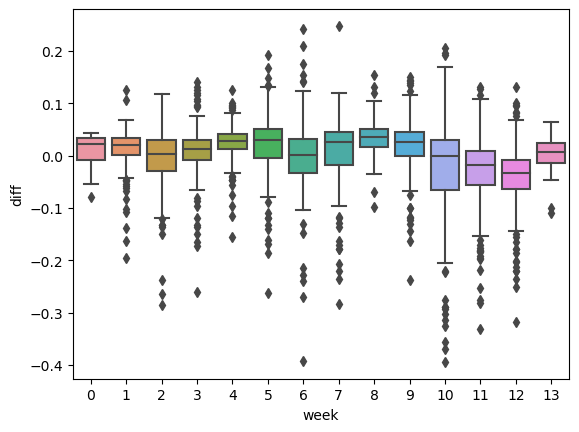

In [12]:
# create the boxplot
sns.boxplot(x='week', y='diff', data=data)
plt.savefig('fig/CO diff boxplot.png', dpi=300)

In [22]:
train_data = pd.concat([sgx_data.loc[train, all_feature], ref_data.loc[train, ['REF-RH', 'REF-AMB_TEMP']], ref_data.loc[train , ['REF-' + target_gas]]] , axis=1)
# val_data = pd.concat([sgx_data.loc[val, all_feature], ref_data.loc[val, ['REF-RH', 'REF-AMB_TEMP']], ref_data.loc[val , ['REF-' + target_gas]]] , axis=1)
test_data = pd.concat([sgx_data.loc[test, all_feature], ref_data.loc[test, ['REF-RH', 'REF-AMB_TEMP']], ref_data.loc[test , ['REF-' + target_gas]]] , axis=1)

Standardization

In [23]:
scaler = StandardScaler()
scaler.fit(train_data)

train_data = scaler.transform(train_data)
# val_data = scaler.transform(val_data)
test_data = scaler.transform(test_data)

Reshape the data

In [31]:
def create_sequences(data, seq_len):
    xs = []
    ys = []

    for i in range(len(data)-seq_len+1):
        x = data[i:i+seq_len, :-1]
        y = data[i+seq_len-1, -1:]
        xs.append(x)
        ys.append(y)

    return torch.tensor(np.stack(xs), dtype=torch.float32), torch.tensor(np.stack(ys), dtype=torch.float32)
seq_len = 6


train_X, train_y = create_sequences(train_data, seq_len)
# val_X, val_y = create_sequences(val_data, seq_len)
test_X, test_y = create_sequences(test_data, seq_len)


In [24]:
# print(train_X.shape, val_X.shape, test_X.shape)
print(train_X.shape, test_X.shape)

torch.Size([1463, 6, 3]) torch.Size([179, 6, 3])


Define the model.

In [25]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

In [27]:
# initialize the model
input_size = 3 + len(additional_feature)
hidden_size = 64
output_size = 1
batch_size = 32
num_epochs = 100

# set random seed for reproducibility
torch.manual_seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = GRUModel(input_size, hidden_size, output_size).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

Using cuda:0 device


Epoch [1/100], Train Loss: 0.8897
Epoch [2/100], Train Loss: 0.8412
Epoch [3/100], Train Loss: 0.7936
Epoch [4/100], Train Loss: 0.7449
Epoch [5/100], Train Loss: 0.6941
Epoch [6/100], Train Loss: 0.6411
Epoch [7/100], Train Loss: 0.5860
Epoch [8/100], Train Loss: 0.5301
Epoch [9/100], Train Loss: 0.4761
Epoch [10/100], Train Loss: 0.4278
Epoch [11/100], Train Loss: 0.3889
Epoch [12/100], Train Loss: 0.3606
Epoch [13/100], Train Loss: 0.3405
Epoch [14/100], Train Loss: 0.3252
Epoch [15/100], Train Loss: 0.3119
Epoch [16/100], Train Loss: 0.2994
Epoch [17/100], Train Loss: 0.2872
Epoch [18/100], Train Loss: 0.2754
Epoch [19/100], Train Loss: 0.2638
Epoch [20/100], Train Loss: 0.2524
Epoch [21/100], Train Loss: 0.2413
Epoch [22/100], Train Loss: 0.2306
Epoch [23/100], Train Loss: 0.2202
Epoch [24/100], Train Loss: 0.2102
Epoch [25/100], Train Loss: 0.2008
Epoch [26/100], Train Loss: 0.1919
Epoch [27/100], Train Loss: 0.1837
Epoch [28/100], Train Loss: 0.1761
Epoch [29/100], Train Loss: 0

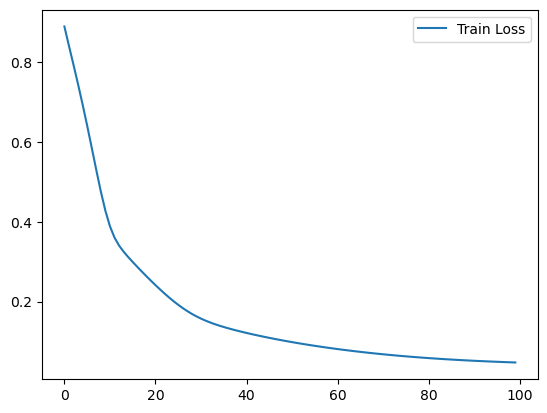

In [28]:
train_log = []

for epoch in range(num_epochs):
    train_loss = 0.0

    # shuffle training data
    indices = torch.tensor(list(range(len(train_X))))

    for i in range(0, train_X.shape[0], batch_size):
        optimizer.zero_grad()

        # get batch of data
        indices_batch = indices[i:i+batch_size]
        batch_X, batch_y = train_X[indices_batch].to(device), train_y[indices_batch].to(device)

        # forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)

        # backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # print average loss for the epoch
    avg_train_loss = train_loss / (train_X.shape[0] / batch_size)
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, num_epochs, avg_train_loss))
    train_log.append(avg_train_loss)

plt.figure()
plt.plot(train_log, label = 'Train Loss')
plt.legend()
plt.show()

***R2 Score: 0.95
***MSE: 0.0454


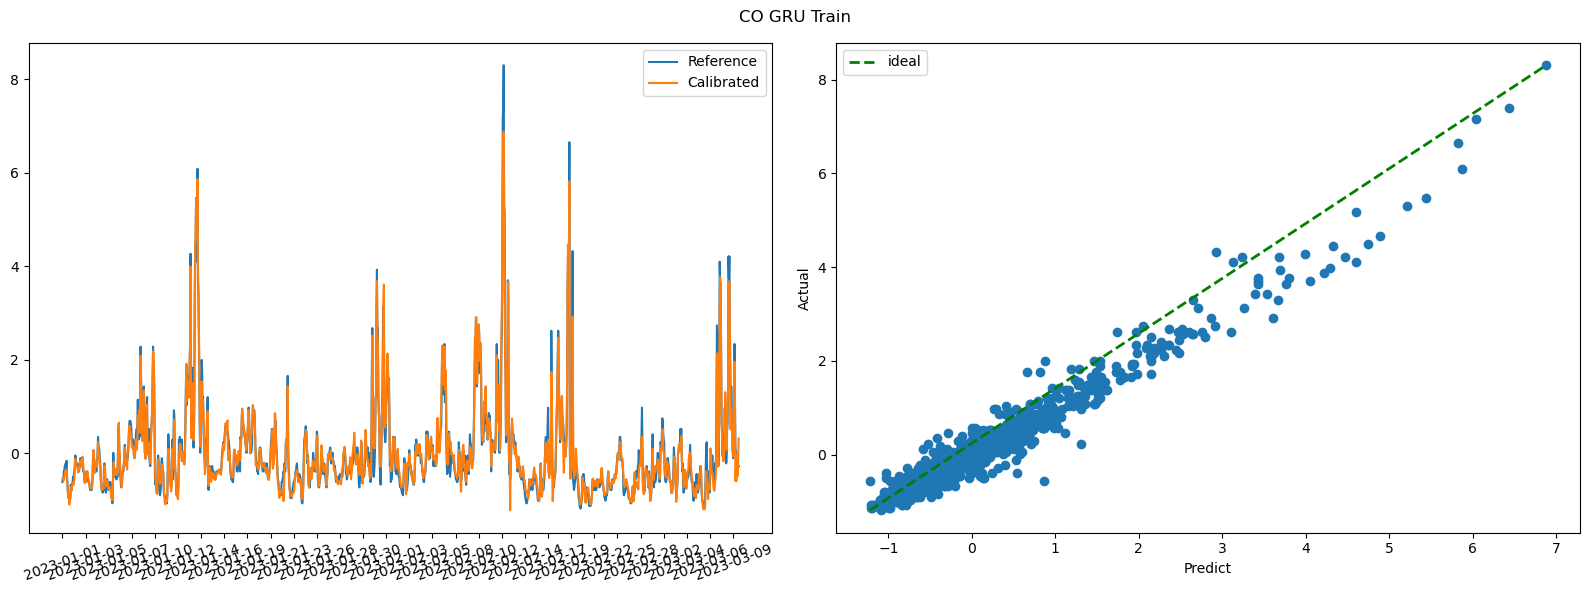

In [29]:
train_outputs = model(train_X.to(device))
score(train_outputs.cpu().detach().numpy(), train_y.numpy())

# plot predicted vs actual values on tain set
visualize_result(train_y.numpy(), train_outputs.cpu().detach().numpy(), train[seq_len-1:], f'{target_gas} GRU Train')

***R2 Score: 0.41
***MSE: 0.1812


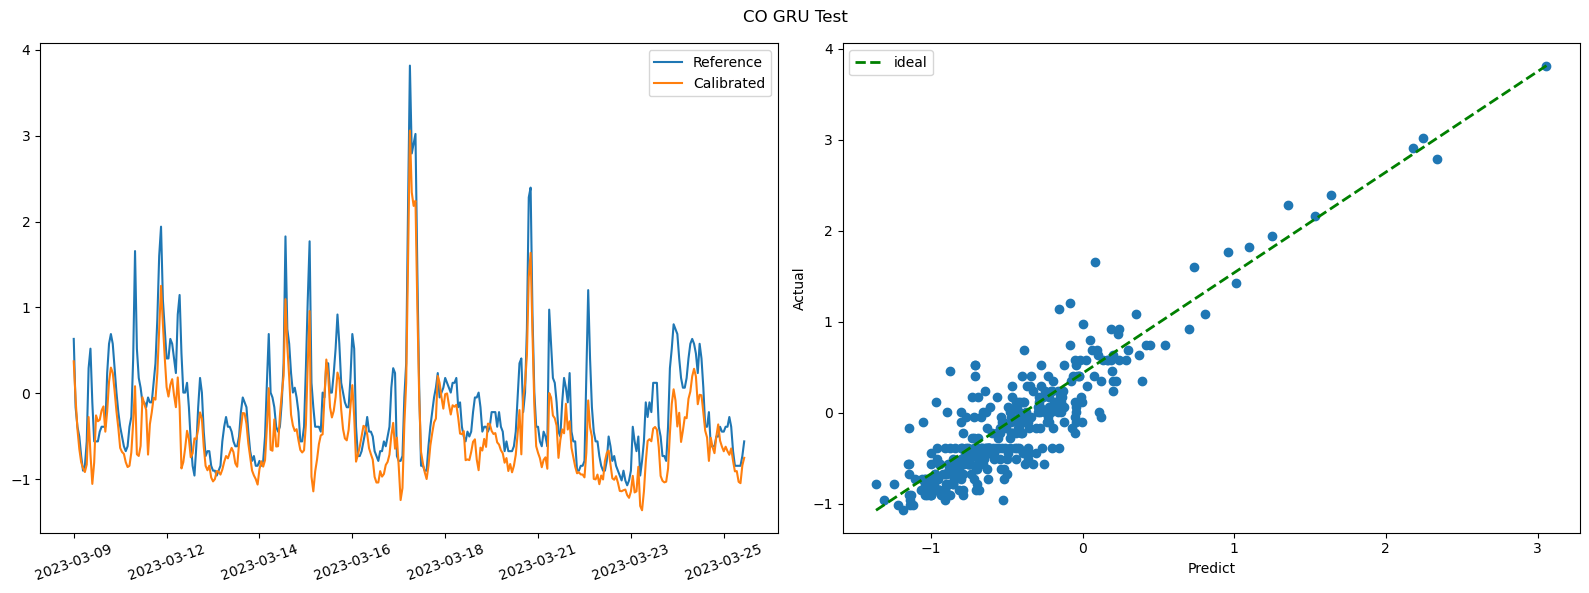

In [32]:
test_outputs = model(test_X.to(device))
score(test_outputs.cpu().detach().numpy(), test_y.numpy())

# plot predicted vs actual values on test set
visualize_result(test_y.numpy(), test_outputs.cpu().detach().numpy(), test[seq_len-1:], f'{target_gas} GRU Test')